[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations, combinations_with_replacement

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# [Thinking like Transformers](https://arxiv.org/abs/2106.06981)

Here we code our 'toy' GPT without any training in order to compute histograms. For the input sequence `<BOS>,a,a,b,a,b,c`, the output should be `0,3,3,2,3,2,1` as the letter `a` appears 3 times, the letter `b` 2 times and the letter `c` once. Each letter is replaced by its number of occurences (except `<BOS>` replaced by a `0`). 

## Self-Attention

First start by coding your Self-Attention layer (do not worry about initialization for the moment).

In [3]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.key_channels = config.key_channels
        self.Query = nn.Linear(self.n_channels, self.key_channels, bias=False)
        self.Key = nn.Linear(self.n_channels, self.key_channels, bias = False)
        self.Value = nn.Linear(self.n_channels, self.n_channels, bias = False)
           
    def _init_id(self):
        self.Query.weight.data = 100*torch.eye(self.key_channels, self.n_channels)
        self.Key.weight.data = 100*torch.eye(self.key_channels,self.n_channels)
        self.Value.weight.data = torch.eye(self.key_channels,self.n_channels)        
        
    def forward(self, x): # x (bs, T, ic)
        Q = self.Query(x) # (bs, T, kc)
        K = self.Key(x)/math.sqrt(self.key_channels) # (bs, T, kc)
        V = self.Value(x) # (bs, T, oc)
        A = # your code here
        y = # your code here
        return y, A

Check your implementation.

In [4]:
class toy_config:
    n_channels = 3
    key_channels = 3
    
sa_toy = SelfAttentionLayer(toy_config)

In [5]:
input = torch.randn(5,10,3)
y,A = sa_toy(input)

In [6]:
y.shape

torch.Size([5, 10, 3])

In [7]:
torch.sum(A, dim=-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)

## identity GPT

We first start with a simple example where we want to contruct the identity map. Clearly, in this case, we can just use the skip connections present in real transformer block. Instead, we will ignore these skip connections and use the self-attention layer. In this practical, we will ignore the layer norm.

To make our life simpler, we encode `<BOS>` with a `0`, letter `a` with a `1` and so on...

If we give as input the sequence `0,1,1,2,3,4,2,3,1`, we want to get the same sequence as output. This is clearly doable with a transformer block as follows:
- take one-hot encoding of each token 
- take Query and Key matrices as `100*Id`
- take Value matrix as `Id`
As a result, the output of the self-attention layer will be the same as the input.

Then take a Feed Forward Network which is simply the identity map as coded below:

In [8]:
class Block_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = (lambda x : x)
        self.attn._init_id()

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [9]:
nb_digits = 4
class config:
    n_channels=nb_digits+1
    key_channels=nb_digits+1

In [10]:
bid = Block_id(config)
one_sample = torch.tensor([[0.,0.,1.,0.,0.],[0.,1.,0.,0.,0.]]).unsqueeze(0)
bid(one_sample)

(tensor([[[0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0.]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[1., 0.],
          [0., 1.]]], grad_fn=<SoftmaxBackward0>))

Now to have really the identity map, we need to project back the one-hot encoding and this can be done with a linear layer (with good weights initialization).

In [11]:
class GPT_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_id(config)
        self.head = nn.Linear(self.n_channels, 1, bias = False)
        self._init_weights()
        
    def _init_weights(self):
        #
        # your code here
        #
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return self.head(x), A

In [12]:
gid = GPT_id(config)

In [13]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gid(one_sample)

In [14]:
y == one_sample

tensor([[True, True, True, True, True, True, True, True, True]])

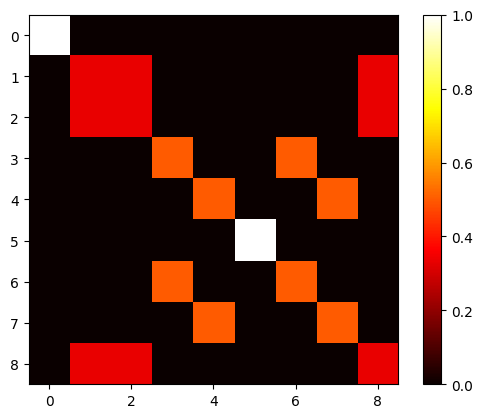

In [15]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## histogram GPT

Now we need to adapt previous case to code our 'toy' transformer block and your 'toy' GPT to compute histograms:
- you will need to find a good initialization for the Quey, Key and Value matrices
- for the feed forward network, you can fake the mlp with any function you'd like.

In [16]:
class Block_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = # your code here
        self.attn._init_hist() # this need to be coded in your self attention layer

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [17]:
class GPT_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_hist(config)
        self._init_weights()
        
    def _init_weights(self):
        #
        # your code here
        #
        
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return x, A

Check your implementation by first choosing properly your configuration:

In [18]:
gh = GPT_hist(config)

In [19]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gh(one_sample)
y

tensor([[[0.],
         [3.],
         [3.],
         [2.],
         [2.],
         [1.],
         [2.],
         [2.],
         [3.]]], grad_fn=<SubBackward0>)

In [20]:
y.shape

torch.Size([1, 9, 1])

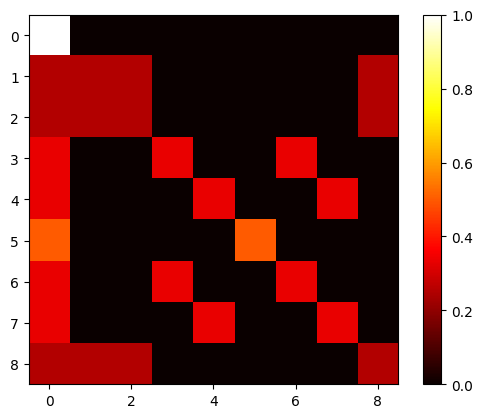

In [21]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Generating your dataset

Now, we will use a 'micro' GPT to learn the task of histograms. Before that, we will use our 'toy' GPT to generate the dataset. Since GPT is equivariant (a permutation of the input will permute the output), we can always take as input a sequence ordered. We can indeed compute all possible different inputs and this number is not too high. For a sequence of lenght `seq_train=s` with at most `nb_digits=n`, there are ${s+n-1 \choose n-1}$ possibilities. Now for each such sequence, we pass it through our toy GPT to get the label.

In [22]:
seq_train = 30
nb_digits = 4
comb = combinations_with_replacement(range(0,seq_train+1), nb_digits-1)

def make_seq(c, seq_train):
    c_l = [0] + list(c) + [seq_train]
    len_seq = len(c_l)-1
    return [c_l[i+1]-c_l[i] for i in range(len_seq)]

l_comb =  [make_seq(c,seq_train) for c in comb]

len(l_comb)

5456

In [23]:
math.comb(seq_train+nb_digits-1, nb_digits-1)

5456

In [24]:
def make_inputs(l_comb, nb_digits=nb_digits):
    inputs = []
    for t in l_comb:
        curr = [0]
        for (i,j) in enumerate(t):
            curr += [i+1 for _ in range(j)]
        inputs.append(torch.tensor(np.array(curr)))
    return inputs

def make_loader(len_seq,nb_digits):
    comb = combinations_with_replacement(range(0,len_seq+1), nb_digits-1)
    l_comb =  [make_seq(c,len_seq) for c in comb]
    inputs = make_inputs(l_comb)
    labels = [(gh(d.unsqueeze(0))[0].squeeze(0).squeeze(1)).type(torch.LongTensor) for d in inputs]
    dataset = list(zip(inputs,labels))
    len_in = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    return loader, len_in, inputs

In [25]:
train_loader, size_train, inputs_train = make_loader(seq_train,nb_digits)

In [26]:
size_train

5456

In [27]:
batch_in = next(iter(train_loader))

In [28]:
batch_in[0].shape

torch.Size([128, 31])

In [29]:
batch_in[1].shape

torch.Size([128, 31])

In [30]:
batch_in[0][0]

tensor([0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

In [31]:
batch_in[1][0]

tensor([ 0,  3,  3,  3,  5,  5,  5,  5,  5,  5, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21])

# Coding 'micro' GPT

Now we need to code the 'micro' GPT used for learning. The game here is to reuse our `SelfAttentionLayer` above without any modification. The only part that is modified is the hard-coded `fake_mlp` which is now replaced by a real MLP.

In [32]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.mlp = # your code here

    def forward(self, x, verbose=False): # x (bs, T,ic)
        #
        # your code here
        #
        if verbose:
            return x, A
        else:
            return x

In [33]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.nb_digits = config.nb_digits
        self.tok_emb = # your code here 
        self.block = Block(config)
        self.head = # your code here 
        
    def forward(self, idx, targets=None, verbose=False):
        # shape of idx: (bs, len) 0=bos and 1...nb_digits
        # shape of targets: (bs, len)
        #
        # your code here
        #
        
        loss = None
        if targets is not None:
            loss = # your code here
        if verbose:
            return logits, loss, A
        else:
            return logits, loss

In [96]:
class config_gpt:
    nb_digits = nb_digits
    n_channels = 32 
    key_channels = 64 
    max_hist = seq_train+1

In [97]:
gptmini = GPT(config_gpt)

In [98]:
logits, _ = gptmini(batch_in[0])

In [99]:
logits.shape

torch.Size([128, 31, 32])

In [100]:
_,preds = torch.max(logits,-1)

In [101]:
preds.shape

torch.Size([128, 31])

In [102]:
batch_in[0].shape

torch.Size([128, 31])

In [103]:
torch.sum(preds == batch_in[1])

tensor(149)

In [104]:
def train_model(model, dataloader, size, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        n_batch = 0
        for inputs,targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits, loss = model(inputs,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #
            # complete the code below:
            _,preds = torch.max(logits,-1)
           
            running_corrects += torch.true_divide(torch.sum(preds == targets.data),targets.shape[0]*targets.shape[1])
            running_loss +=  loss.data.item()
            n_batch += 1
        epoch_loss = running_loss /n_batch
        epoch_acc = running_corrects.data.item() /n_batch
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [105]:
gptmini = GPT(config_gpt)
gptmini = gptmini.to(device)
lr = 0.01
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)

In [106]:
len_train = (seq_train+1)*size_train
train_model(gptmini,train_loader,size_train,15,optimizer)

Loss: 2.8756 Acc: 0.1483
Loss: 2.6111 Acc: 0.1812
Loss: 2.4962 Acc: 0.2020
Loss: 2.4098 Acc: 0.2116
Loss: 2.3446 Acc: 0.2268
Loss: 2.4303 Acc: 0.2116
Loss: 2.2728 Acc: 0.2539
Loss: 2.1939 Acc: 0.2580
Loss: 2.1879 Acc: 0.2608
Loss: 2.2848 Acc: 0.2473
Loss: 2.1950 Acc: 0.2698
Loss: 2.0979 Acc: 0.2993
Loss: 1.9010 Acc: 0.3331
Loss: 1.6563 Acc: 0.4243
Loss: 1.8152 Acc: 0.4012


In [107]:
lr = 0.005
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 1.5810 Acc: 0.4741
Loss: 1.2393 Acc: 0.6118
Loss: 1.1332 Acc: 0.6218
Loss: 0.9543 Acc: 0.6832
Loss: 0.7856 Acc: 0.7692
Loss: 0.6970 Acc: 0.7743
Loss: 0.7211 Acc: 0.7412
Loss: 0.5601 Acc: 0.8607
Loss: 0.6647 Acc: 0.8043
Loss: 0.6082 Acc: 0.8089
Loss: 0.4293 Acc: 0.9076
Loss: 0.3764 Acc: 0.9298
Loss: 0.3589 Acc: 0.9287
Loss: 0.3499 Acc: 0.9167
Loss: 0.3006 Acc: 0.9333


In [108]:
lr = 0.001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.2984 Acc: 0.9319
Loss: 0.2184 Acc: 0.9859
Loss: 0.2108 Acc: 0.9866
Loss: 0.2009 Acc: 0.9882
Loss: 0.1927 Acc: 0.9877
Loss: 0.1865 Acc: 0.9895
Loss: 0.1764 Acc: 0.9908
Loss: 0.1680 Acc: 0.9919
Loss: 0.1615 Acc: 0.9919
Loss: 0.1539 Acc: 0.9928
Loss: 0.1458 Acc: 0.9944
Loss: 0.1413 Acc: 0.9937
Loss: 0.1362 Acc: 0.9933
Loss: 0.1282 Acc: 0.9951
Loss: 0.1183 Acc: 0.9965


In [109]:
lr = 0.0001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.1099 Acc: 0.9971
Loss: 0.1074 Acc: 0.9978
Loss: 0.1067 Acc: 0.9976
Loss: 0.1055 Acc: 0.9982
Loss: 0.1043 Acc: 0.9974
Loss: 0.1031 Acc: 0.9978
Loss: 0.1023 Acc: 0.9983
Loss: 0.1009 Acc: 0.9978
Loss: 0.1001 Acc: 0.9979
Loss: 0.0988 Acc: 0.9978
Loss: 0.0982 Acc: 0.9981
Loss: 0.0969 Acc: 0.9984
Loss: 0.0959 Acc: 0.9981
Loss: 0.0947 Acc: 0.9980
Loss: 0.0940 Acc: 0.9981


In [110]:
one_batch = batch_in[0].to(device)
logits, loss, A = gptmini(one_batch,verbose=True)
A.shape

torch.Size([128, 31, 31])

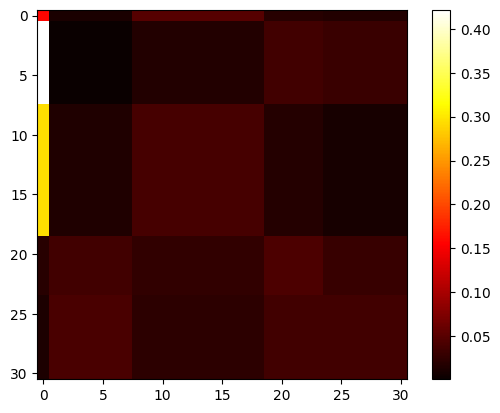

In [111]:
k = 45
plt.imshow(A[k,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)